<a href="https://colab.research.google.com/github/juanninocruz/Estadistica/blob/main/Cuaderno17_K-Mediods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**17.3 Taller Clustering de Clientes con K-Medoids**

Vamos a realizar el mismo taller de clusterización de Kmeans usando Kmedoids y a verificar la diferencia. El algoritmo K-medoids lo descargamos de la clase KMedoids de la librería sklearn_extra.

Recuerde transcribir los scripts de código de python en el ambiente de desarrollo de su preferencia.

**Inicialmente debemos instalar scikit-learn-extra**

In [1]:
!pip install numpy==1.26.4
!pip install --upgrade scikit-learn scikit-learn-extra

  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (9.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


**Cargar y Preprocesar los Datos**


Este bloque de código realiza una serie de pasos fundamentales para cargar, procesar y visualizar un conjunto de datos. A continuación, explico cada paso del código proporcionado.

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

# Cargar los datos desde la URL
url = "https://raw.githubusercontent.com/adiacla/bigdata/refs/heads/master/Shopping_CustomerData.csv"
data = pd.read_csv(url)
# Visualizar las primeras filas de los datos
data

,ID,Genero,Edad,Ciudad,Ingresos,Credito,gastos,trabajo
0,1001,Male,49,Bengaluru,527547.58850,653,78,1
1,1002,Male,59,Bengaluru,207143.19760,630,63,1
2,1003,Female,54,Delhi,164423.84570,555,69,4
3,1004,Female,42,Bengaluru,56220.36443,699,30,1
4,1005,Female,30,Bengaluru,256194.36190,793,6,1
...,...,...,...,...,...,...,...,...
195,1196,Female,54,Delhi,317466.42070,601,52,4
196,1197,Female,20,Bengaluru,323305.50020,554,58,1
197,1198,Male,44,Chennai,109058.54430,844,36,2
198,1199,Male,28,Delhi,160116.89300,837,24,4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        200 non-null    int64  
 1   Genero    200 non-null    object 
 2   Edad      200 non-null    int64  
 3   Ciudad    200 non-null    object 
 4   Ingresos  200 non-null    float64
 5   Credito   200 non-null    int64  
 6   gastos    200 non-null    int64  
 7   trabajo   200 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 12.6+ KB


In [4]:
data.describe()

,ID,Edad,Ingresos,Credito,gastos,trabajo
count,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000
mean,1100.500000,45.520000,285143.931646,719.975000,50.70500,2.850000
std,57.879185,16.113592,169229.187619,104.578236,28.72269,1.475938
min,1001.000000,18.000000,2577.057456,551.000000,2.00000,1.000000
25%,1050.750000,31.750000,153227.340950,628.250000,27.75000,1.750000
50%,1100.500000,46.500000,263418.505550,715.000000,48.00000,3.000000
75%,1150.250000,59.000000,384857.116200,806.250000,77.00000,4.000000
max,1200.000000,75.000000,695407.091700,897.000000,100.00000,5.000000


In [5]:
data.isnull().sum()

,0
ID,0
Genero,0
Edad,0
Ciudad,0
Ingresos,0
Credito,0
gastos,0
trabajo,0


**Verificar que no hayan outliers**


El código genera un gráfico de caja y bigotes (boxplot) para las columnas numéricas del conjunto de datos.

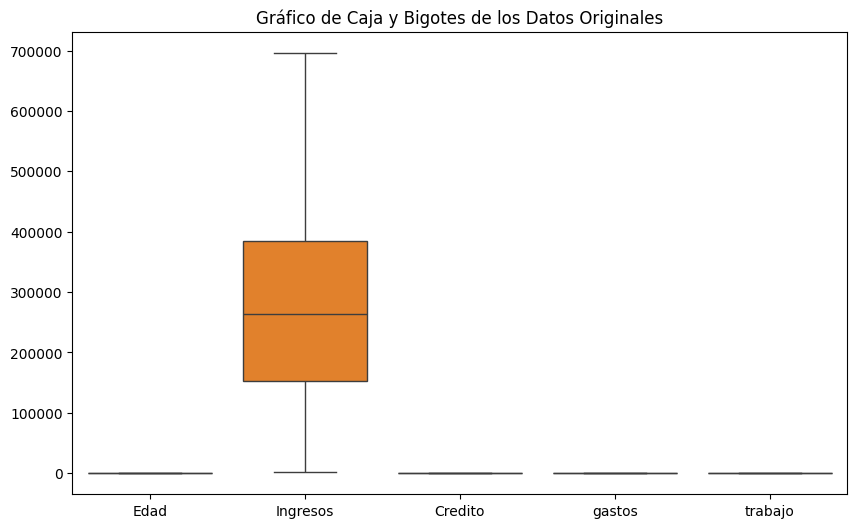

In [6]:
# Seleccionar sólo las columnas numéricas
numerical_data = data[['Edad', 'Ingresos', 'Credito', 'gastos', 'trabajo']]
# Crear el gráfico de caja y bigotes
plt.figure(figsize=(10, 6))
sns.boxplot(data=numerical_data)
plt.title('Gráfico de Caja y Bigotes de los Datos Originales')
plt.show()

**Codificar la variable 'Genero' (Male = 0, Female = 1):**


Primero, se codifica la variable categórica 'Genero' (Male = 0, Female = 1) para convertirla en una forma numérica. Luego, se seleccionan las columnas numéricas relevantes para el análisis (Edad, Ingresos, Credito, Gastos, Trabajo, y Genero), y se eliminan las no necesarias, como ID y Ciudad.

A continuación, normalizamos los datos utilizando el StandardScaler de scikit-learn, asegurando que todas las variables tengan la misma escala (media 0 y desviación estándar 1). Esto es crucial para que ninguna variable, como Ingresos, domine las distancias calculadas en el algoritmo K-means. El
resultado es un conjunto de datos listos para ser procesados y segmentados en grupos utilizando técnicas de clustering.

In [19]:
# Codificar la variable 'Genero' (Male = 0, Female = 1)
data['Genero'] = data['Genero'].map({'Male': 0, 'Female': 1})
# Seleccionar las columnas numéricas para la segmentación (eliminando ID y Ciudad)
data_numeric = data[['Edad', 'Ingresos', 'Credito', 'gastos', 'trabajo', 'Genero']]
# Normalizar los datos numéricos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)
# Visualizar las primeras filas de los datos escalados
data_scaled

array([[ 0.2165087 ,  1.43599311, -0.64203672,  0.95267867, -1.25658588,
        -1.12815215],
       [ 0.83866013, -0.46207437, -0.86251966,  0.42913296, -1.25658588,
        -1.12815215],
       [ 0.52758441, -0.71514273, -1.58148576,  0.63855125,  0.78112095,
         0.88640526],
       ...,
       [-0.09456702, -1.04312537,  1.18893027, -0.51324931, -0.57735027,
        -1.12815215],
       [-1.0900093 , -0.74065701,  1.12182677, -0.93208587,  0.78112095,
        -1.12815215],
       [-0.28121245, -0.02999037,  0.66168846, -0.68776454, -0.57735027,
        -1.12815215]])

**Para determinar el número óptimo de clústeres, utilizaremos el método del codo.**

Aplicaremos el método codo, para determinar el número de clúster recomendado, en la imagen se observa una variación alta antes del 13.
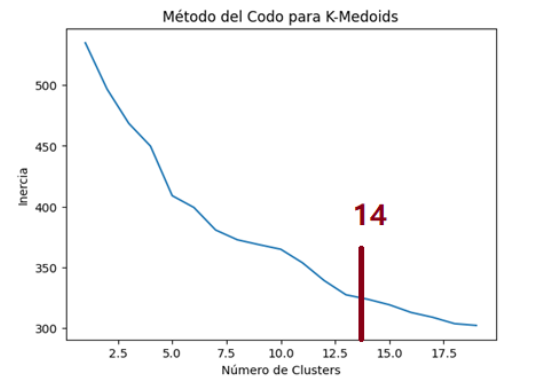

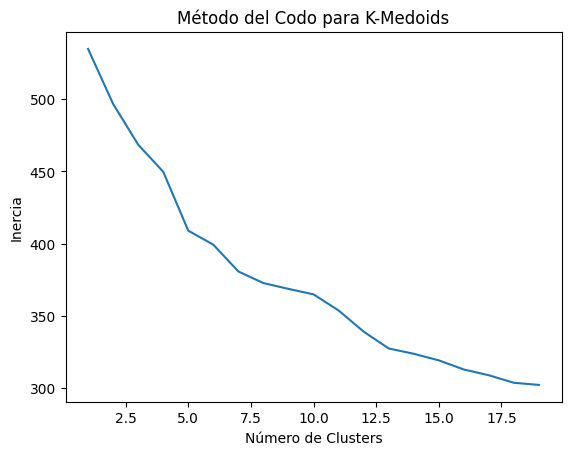

In [20]:
# Método del Codo: Calcular la inercia (suma de distancias dentro de los clústeres)
inertia = []
for k in range(1, 20):
  # Probar con diferentes números de clústeres (k)
  kmedoids = KMedoids(n_clusters=k, random_state=42)
  kmedoids.fit(data_scaled)
  inertia.append(kmedoids.inertia_)
# Graficar el método del codo
plt.plot(range(1, 20), inertia)
plt.title("Método del Codo para K-Medoids")
plt.xlabel("Número de Clusters")
plt.ylabel("Inercia")
plt.show()

***Aplicación del Método de Silhouette al Taller***


Para agrupar los datos, utilizamos el método del codo; pero ahora vamos a usar el método silhouette para validar la calidad
de la segmentación.

**Determinación del Número Óptimo de Clústeres**


Calculamos el coeficiente de silhouette para diferentes valores de 𝑘 (número de clústeres). En este caso práctico:
Probamos valores de 𝑘 desde 2 hasta 20.
El 𝑘 que maximiza la media del coeficiente de silhouette entre todas las observaciones se considera el número óptimo de clústeres.

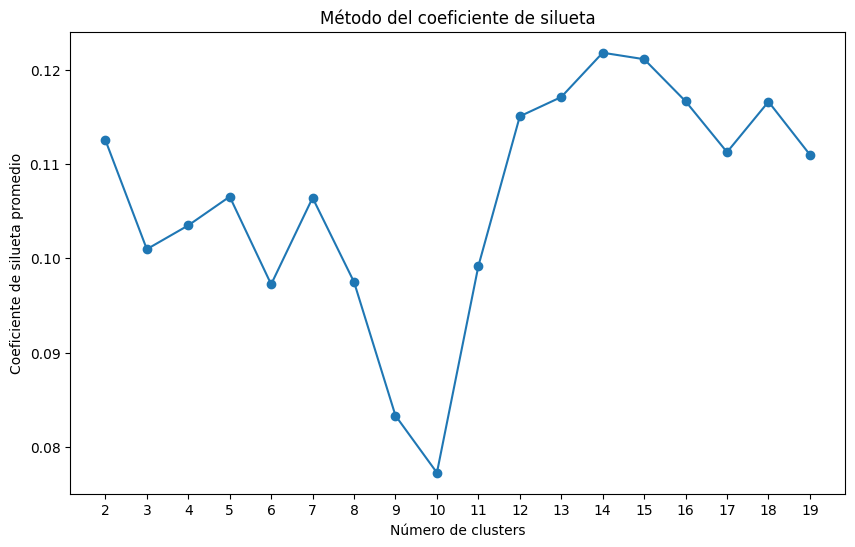

Número óptimo de clusters: 14


In [21]:
from sklearn.metrics import silhouette_score
# Definir el rango de posibles números de clústeres
range_clusters = range(2, 20)
# Lista para almacenar las puntuaciones de silueta
silhouette_scores = []
# Calcular el coeficiente de silueta para cada número de clústeres
for k in range_clusters:
  kmeans = KMedoids(n_clusters=k, random_state=42)
  cluster_labels = kmeans.fit_predict(data_scaled)
  silhouette_avg = silhouette_score(data_scaled, cluster_labels)
  silhouette_scores.append(silhouette_avg)
# Graficar el promedio del coeficiente de silueta
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title("Método del coeficiente de silueta")
plt.xlabel("Número de clusters")
plt.ylabel("Coeficiente de silueta promedio")
plt.xticks(range_clusters)
plt.show()

# Número óptimo de clústeres basado en el máximo valor del coeficiente de silueta
optimal_clusters = range_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Número óptimo de clusters: {optimal_clusters}")

En el método del Coeficiente de Silueta, se toma el valor más alto del coeficiente promedio para determinar el número óptimo de clústeres, en este caso sería 14.

El razonamiento detrás de esto es que un valor de silueta cercano a 1 indica que los puntos están bien agrupados dentro de su clúster y bien separados de los demás clústeres. Por tanto:

**Silhouette cercano a 1:** buena asignación al clúster correcto.

**Silhouette cercano a 0:** los puntos están en los límites entre clústeres.

**Silhouette negativo (< 0):** mala asignación, el punto pertenece más al clúster vecino. El número de clústeres que maximiza el promedio del coeficiente de silueta (considerando todas las observaciones) es considerado el número
óptimo.

Así el agrupamiento más recomendable sería 14.

**Asignar el clúster a cada cliente de los 14 clústeres**

                  ID    Genero       Edad       Ingresos     Credito  \
Cluster                                                                
0        1081.727273  1.000000  52.818182  437040.640664  693.909091   
1        1097.833333  1.000000  67.833333  143788.391730  623.166667   
2        1102.714286  0.952381  25.000000  377633.122354  800.380952   
3        1110.833333  0.000000  39.888889  224437.757979  829.888889   
4        1104.000000  1.000000  49.923077  113685.345576  783.384615   
5        1115.000000  1.000000  54.125000  545833.654975  830.375000   
6        1106.166667  0.000000  47.388889  371936.137890  618.444444   
7        1073.777778  1.000000  46.444444  143905.404823  741.444444   
8        1064.250000  1.000000  70.500000  362060.542300  854.750000   
9        1086.800000  1.000000  39.533333  259064.543565  748.666667   
10       1097.484848  0.000000  56.000000  258633.815964  712.454545   
11       1127.000000  1.000000  39.692308  297432.057553  594.00

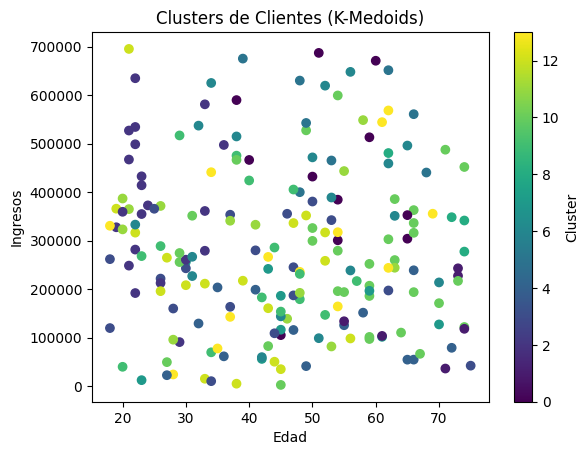

In [22]:
# Aplicar K-Medoids
kmedoids = KMedoids(n_clusters=14, random_state=42, metric='euclidean')
data['Cluster'] = kmedoids.fit_predict(data_scaled)
# Análisis por clúster
cluster_summary = data[['ID', 'Genero', 'Edad', 'Ingresos', 'Credito', 'gastos', 'Cluster']].groupby('Cluster').mean()
print(cluster_summary)
# Visualizar clústeres con 'Edad' e 'Ingresos'
plt.scatter(data['Edad'], data['Ingresos'], c=data['Cluster'], cmap='viridis')
plt.title("Clusters de Clientes (K-Medoids)")
plt.xlabel('Edad')
plt.ylabel('Ingresos')
plt.colorbar(label='Cluster')
plt.show()

In [23]:
from sklearn.metrics import silhouette_score
# Coeficiente de Silueta para evaluar la calidad de los clústeres
silhouette_avg = silhouette_score(data_scaled, data['Cluster'])
print(f"El coeficiente de silueta promedio es: {silhouette_avg}")

El coeficiente de silueta promedio es: 0.1217795773712587


El coeficiente de silueta promedio es: 0.1217795773712587

* Compare este coeficiente con el obtenido en el kmeans para determinar cuál de los dos métodos tiene mejor inercia. Para este caso debido a que la incercia para Kmeans es de 0.1806997246685652; es mejor la inercia de Kmeans. El KMeans tiene una mejor silueta, lo que indica que sus clústeres están más compactos y mejor separados.

**Conclusión**

Identificamos 14 clústeres de clientes, cada uno con características demográficas y de gasto únicas.
Este enfoque es más robusto frente a valores extremos, lo que puede ser útil en contextos con datos ruidosos o valores atípicos. Los resultados son comparables a los obtenidos con K-Means, pero los centroides (medoids) representan puntos reales del conjunto de datos, facilitando la interpretación.